# AllLife Bank Customer Segmentation

## Background & Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help
### Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

## Data Dictionary:
* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of visits that customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

In [1]:
# Course: Unsupervised Learning
# Project: AllLife Bank Customer Segmentation
# Student: Sameer Girolkar
# Date: Feb 4, 2022

In [2]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet


# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

<IPython.core.display.Javascript object>

### Functions for EDA and Visualizations

In [4]:
# function to plot histogram and barplot together
def histogram_boxplot(
    data, feature, figsize=(12, 7), kde=False, bins=None, hue=None, element="bars"
):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet", hue=hue
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data,
        x=feature,
        kde=kde,
        ax=ax_hist2,
        bins=bins,
        palette="winter",
        hue=hue,
        element=element,
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, hue=hue, element=element
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(data[feature].median(), color="black", linestyle="-")

<IPython.core.display.Javascript object>

In [5]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None, hue=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    hue: Grouping variable
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 5, 5))
    else:
        plt.figure(figsize=(n + 5, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
        hue=hue,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

In [6]:
# function to create box-plots by category
def box_plot_by_cat(data, category_col, y, n=None):
    """
    Boxplot by category

    data: dataframe
    category_col: column for which the boxplot will be created
    y: independent variable
    n: no of values to plot
    """
    count = data[category_col].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))
    sns.boxplot(
        x=category_col,
        y=y,
        data=data,
        order=data[category_col].value_counts().index[:n].sort_values(),
    )
    plt.xticks(rotation=90)
    plt.show()

<IPython.core.display.Javascript object>

In [7]:
# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 75)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    ax = tab.plot(kind="bar", stacked=True, figsize=(count + 7, 6))

    for c in ax.containers:
        ax.bar_label(c, label_type="center", size=14, fmt="%.2f")

    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title=target)
    plt.show()

<IPython.core.display.Javascript object>

In [8]:
# Removes the limit from the number of displayed columns
pd.set_option("display.max_columns", None)

# Let's set the limit of 200 rows max
pd.set_option("display.max_rows", 200)

<IPython.core.display.Javascript object>

In [9]:
# make the graphs look nicer
sns.set(color_codes=True)
sns.set_style("darkgrid")
# light palette for Pivot tables
cm = sns.light_palette("lightblue", as_cmap=True)
sns.set(
    rc={
        "figure.figsize": (15, 15),
        "axes.titlesize": "30",
        "xtick.labelsize": "20",
        "ytick.labelsize": "20",
    }
)

# actually display the graphs instead of generating only the object
%matplotlib inline

<IPython.core.display.Javascript object>

## Overview of the Dataset
Let's now read and observe the data

In [10]:
# Read the data from the file
data = pd.read_excel("Credit+Card+Customer+Data.xlsx")

<IPython.core.display.Javascript object>

In [11]:
# lets see how many rows and columns are present in the data
data.shape

(660, 7)

<IPython.core.display.Javascript object>

In [12]:
# Check data types and number of non-null values for each column.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

### Observations:
- All columns are numeric
- None of the columns have nulls

In [13]:
data.head(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
5,6,58634,20000,3,0,1,8
6,7,48370,100000,5,0,11,2
7,8,37376,15000,3,0,1,1
8,9,82490,5000,2,0,2,2
9,10,44770,3000,4,0,1,7


<IPython.core.display.Javascript object>

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


<IPython.core.display.Javascript object>

## Observations
* Average credit limit values are much higher than the other columns

## Data Preprocessing

Sl_No and Customer Key columns are assigned to a customer.<br>
These coolumns are not really providing any meaningful information about a customer's profile.<br>
We should drop these columnns

In [15]:
# lets keep a copy of the data for any future reference
data_org = data.copy()

<IPython.core.display.Javascript object>

In [16]:
# Drop Id columns
data.drop(["Sl_No", "Customer Key"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

## EDA

## Univariate Analysis

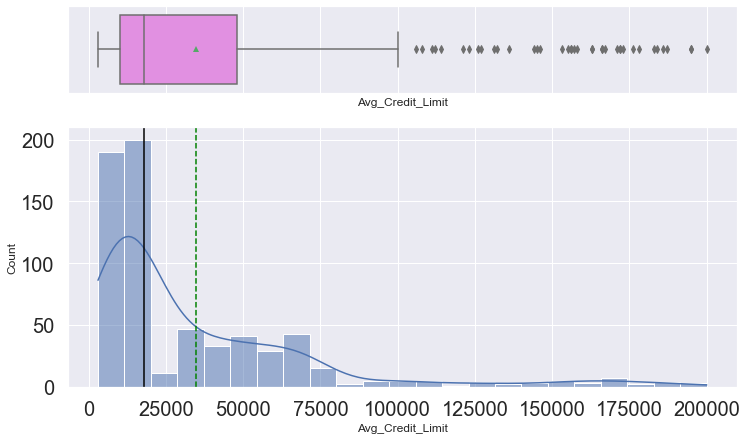

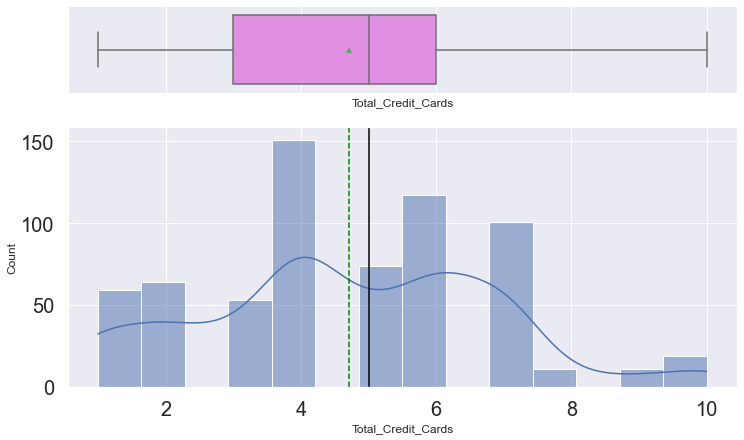

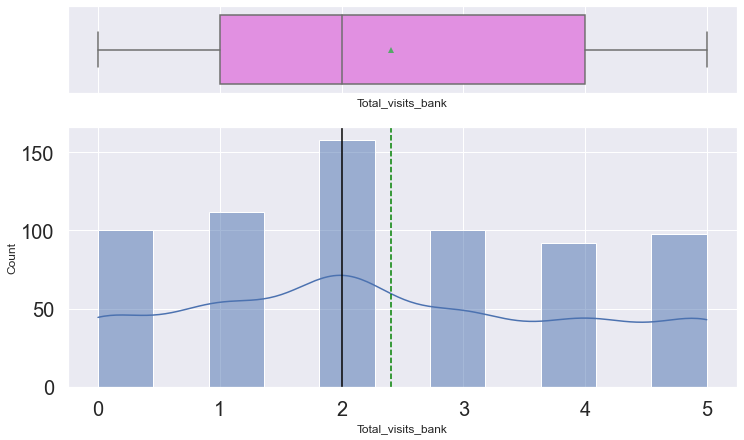

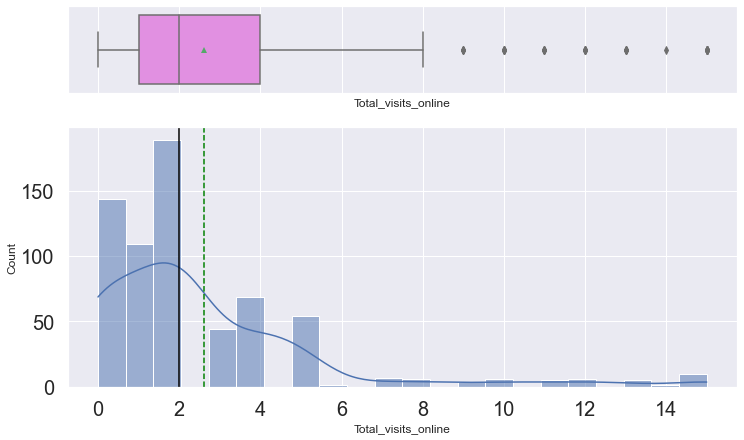

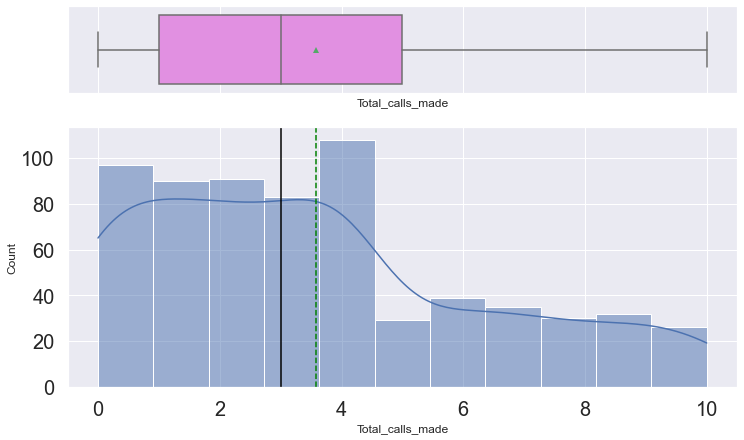

<IPython.core.display.Javascript object>

In [17]:
for col in data.columns:
    histogram_boxplot(data, col, kde=True)

### Observations
* Avg_Credit_Limit, Total_Visits_online and Total_calls_made values are right skewed.
* Avg_Credit_Limit and Total_visits_online columns have outliers
* Most customres have credit limits less than 25000

## Bivariate Analysis

Lets take a look at the correlations between the columns

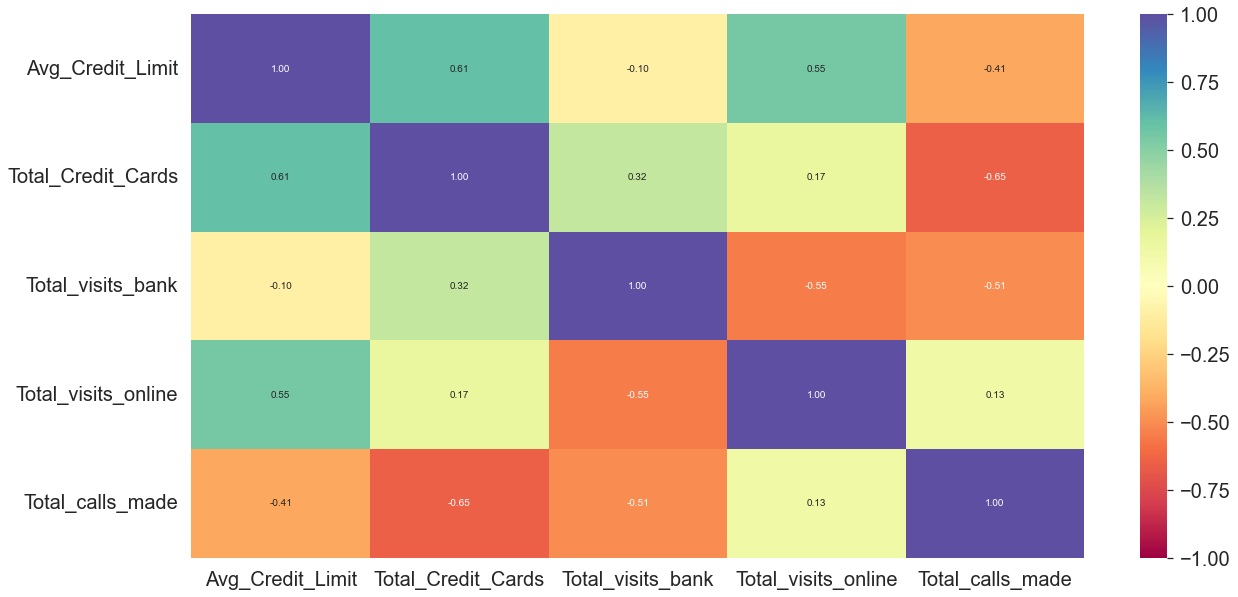

<IPython.core.display.Javascript object>

In [18]:
plt.figure(figsize=(20, 10))
hm = sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

### Observations
* There are no strong correlations beweenn the columns

<Figure size 1080x504 with 0 Axes>

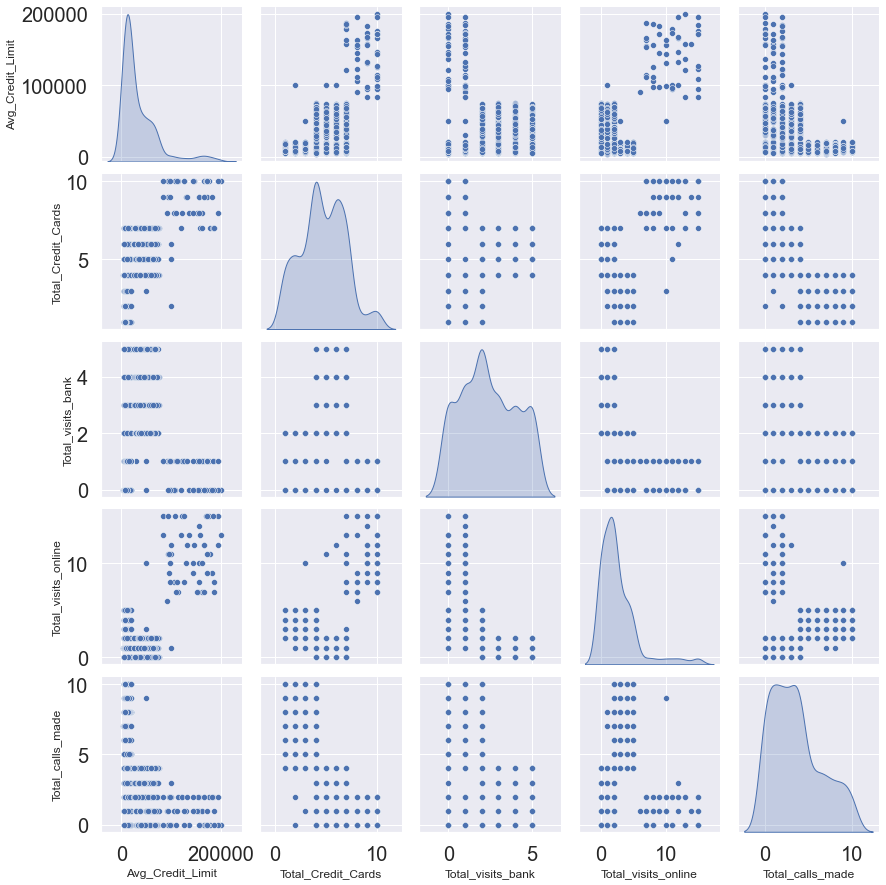

<IPython.core.display.Javascript object>

In [19]:
plt.figure(figsize=(15, 7))
sns.pairplot(data=data, diag_kind="kde")
plt.show()

## Scalling the data

In [20]:
# Scaling the data set before clustering
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
# Creating a dataframe from the scaled data
scaled_df = pd.DataFrame(data_scaled, columns=data.columns)
# lets make a copy for HC
scaled_df_hc = scaled_df.copy()

<IPython.core.display.Javascript object>

## K-Means Clustering

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9907468928853334
Number of Clusters: 6 	Average Distortion: 0.9430843103448057
Number of Clusters: 7 	Average Distortion: 0.9093703386475
Number of Clusters: 8 	Average Distortion: 0.8893736336416194
Number of Clusters: 9 	Average Distortion: 0.8668506802405983
Number of Clusters: 10 	Average Distortion: 0.8420878747557231


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

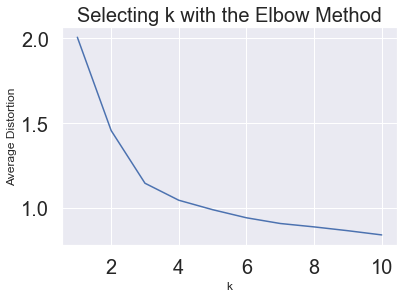

<IPython.core.display.Javascript object>

In [21]:
clusters = range(1, 11)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(scaled_df)
    prediction = model.predict(scaled_df)
    distortion = (
        sum(
            np.min(cdist(scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

**The appropriate value of k from the elbow curve seems to be 3 or 4.**

**Let's check the silhouette scores.**

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2717470361089752
For n_clusters = 6, silhouette score is 0.25545029453623114
For n_clusters = 7, silhouette score is 0.24821050966368377
For n_clusters = 8, silhouette score is 0.22648088517730564
For n_clusters = 9, silhouette score is 0.2132811087288363


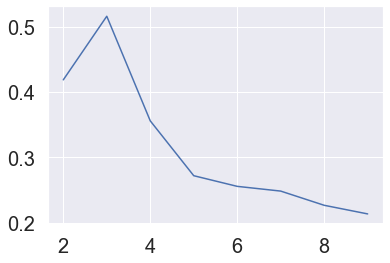

<IPython.core.display.Javascript object>

In [22]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**From the silhouette scores, it seems that 3 is a good value of k.**

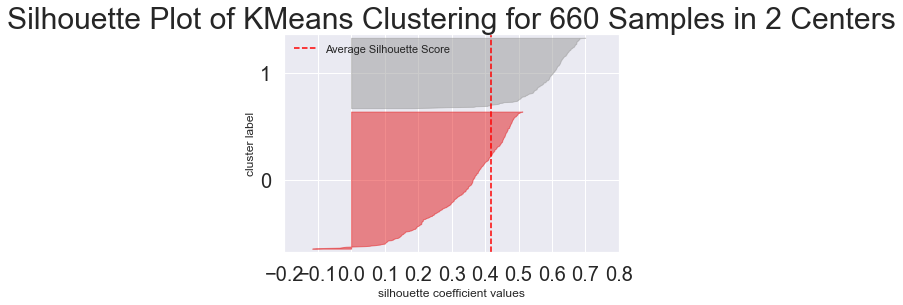

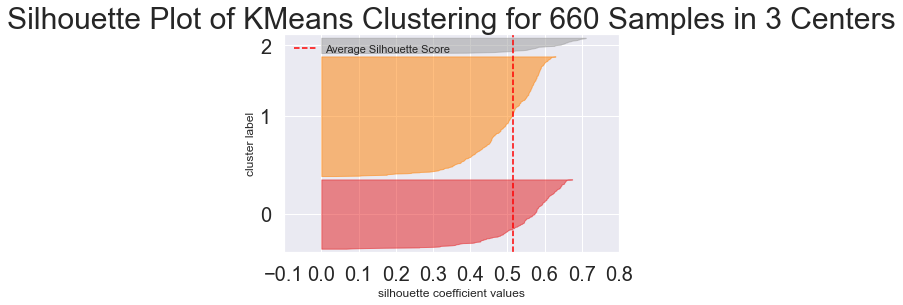

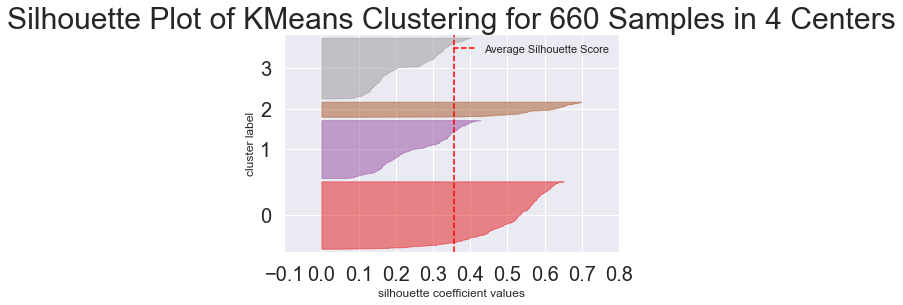

<IPython.core.display.Javascript object>

In [23]:
# finding optimal no. of clusters with silhouette coefficients
for num_clusters in [2,3,4]:
    visualizer = SilhouetteVisualizer(KMeans(num_clusters, random_state=1))
    visualizer.fit(scaled_df)
    visualizer.show()

**silhouette coefficients confirm 3 to be the optimal no. of clusters**

In [24]:
# K-means Clustering
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(scaled_df)

KMeans(n_clusters=3, random_state=0)

<IPython.core.display.Javascript object>

In [25]:
# adding kmeans cluster labels to the original dataframe
data["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

In [26]:
cluster_profile = data.groupby("K_means_segments").mean()

<IPython.core.display.Javascript object>

In [27]:
cluster_profile["count_in_each_segment"] = (
    data.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [28]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

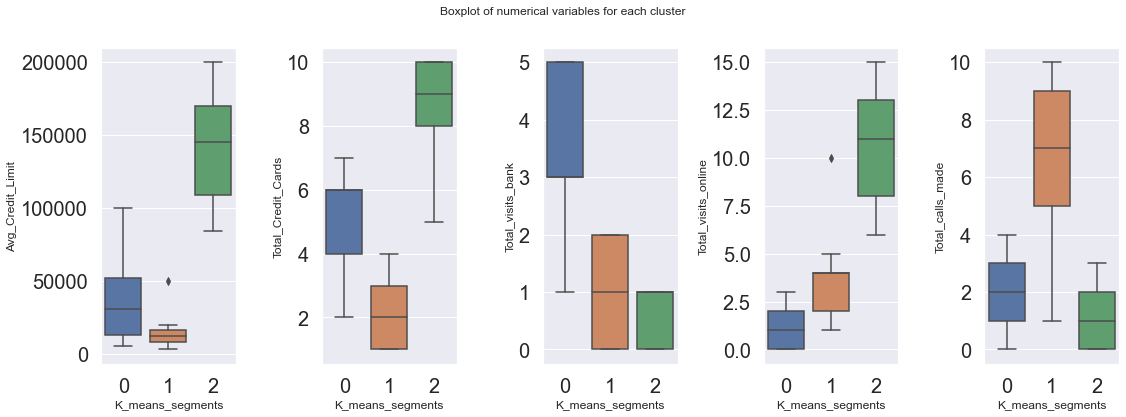

<IPython.core.display.Javascript object>

In [29]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=data[data.columns[counter]], x=data["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

<AxesSubplot:xlabel='K_means_segments'>

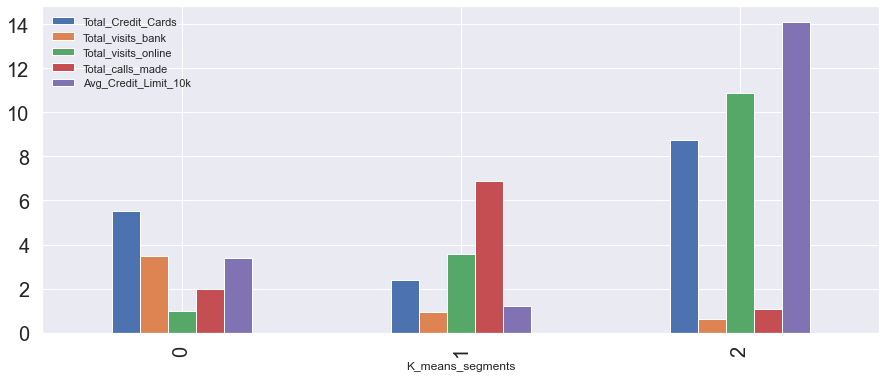

<IPython.core.display.Javascript object>

In [30]:
# for display purposes lets plot Avg_Credit_Limit per 10k
data["Avg_Credit_Limit_10k"] = data["Avg_Credit_Limit"]/10000
data.drop("Avg_Credit_Limit",axis=1).groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

### Insights based on K-means Clustering
Using K-means Clustering customes can be grouped in 3 clusters

### Cluster 1:
* There are 386 customers in this cluster
* Average Credit Limit around 35000
* Has around 5 credit cards
* Vists the bank about 3 times in a year
* Visits about 1 times online in a year
* Makes about 2 calls to the customer service in a year

### Cluster 2:
* There are 224 customers in this cluster
* Average Credit Limit around 10000
* Has around 2 to 3 credit cards
* Vists the bank about 1 time in a year
* Visits about 3 time online in a year
* Makes about 7 calls to the customer service in a year

### Cluster 3:
* There are 50 customers in this cluster
* Average Credit Limit around 140000
* Has around 9 credit cards
* Vists the bank less than 1 time in a year
* Visits about 11 times online in a year
* Makes about 1 call to the customer service in a year

## Hierarchical Clustering

In [31]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

cophenetic_corr = []
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(scaled_df_hc, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(scaled_df))
        cophenetic_corr.append((dm, lm, c))

<IPython.core.display.Javascript object>

**Let's explore additional linkage methods with Euclidean distance only.**

In [32]:
# list of linkage methods
linkage_methods = ["centroid", "ward"]

for lm in linkage_methods:
    Z = linkage(scaled_df_hc, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(scaled_df))
    cophenetic_corr.append(("euclidean", lm, c))

<IPython.core.display.Javascript object>

In [33]:
cophenetic_corr_df = pd.DataFrame(cophenetic_corr, columns=["Distance", "Linkage", "correlation"])
cophenetic_corr_df.sort_values(by="correlation", inplace=True, ascending=False)
cophenetic_corr_df.reset_index(drop=True, inplace=True)
cophenetic_corr_df

,Distance,Linkage,correlation
0,euclidean,average,0.897708
1,chebyshev,average,0.897416
2,cityblock,average,0.896329
3,euclidean,centroid,0.893939
4,chebyshev,weighted,0.891362
5,euclidean,weighted,0.886175
6,cityblock,weighted,0.882552
7,cityblock,complete,0.873148
8,euclidean,complete,0.859973
9,chebyshev,complete,0.853347


<IPython.core.display.Javascript object>

**Highest cophenetic correlation still remains 0.897708, which is obtained with Euclidean distance and average linkage.**

**Let's see the dendrograms for the top 5 Combinations of Distance and Linkage.**

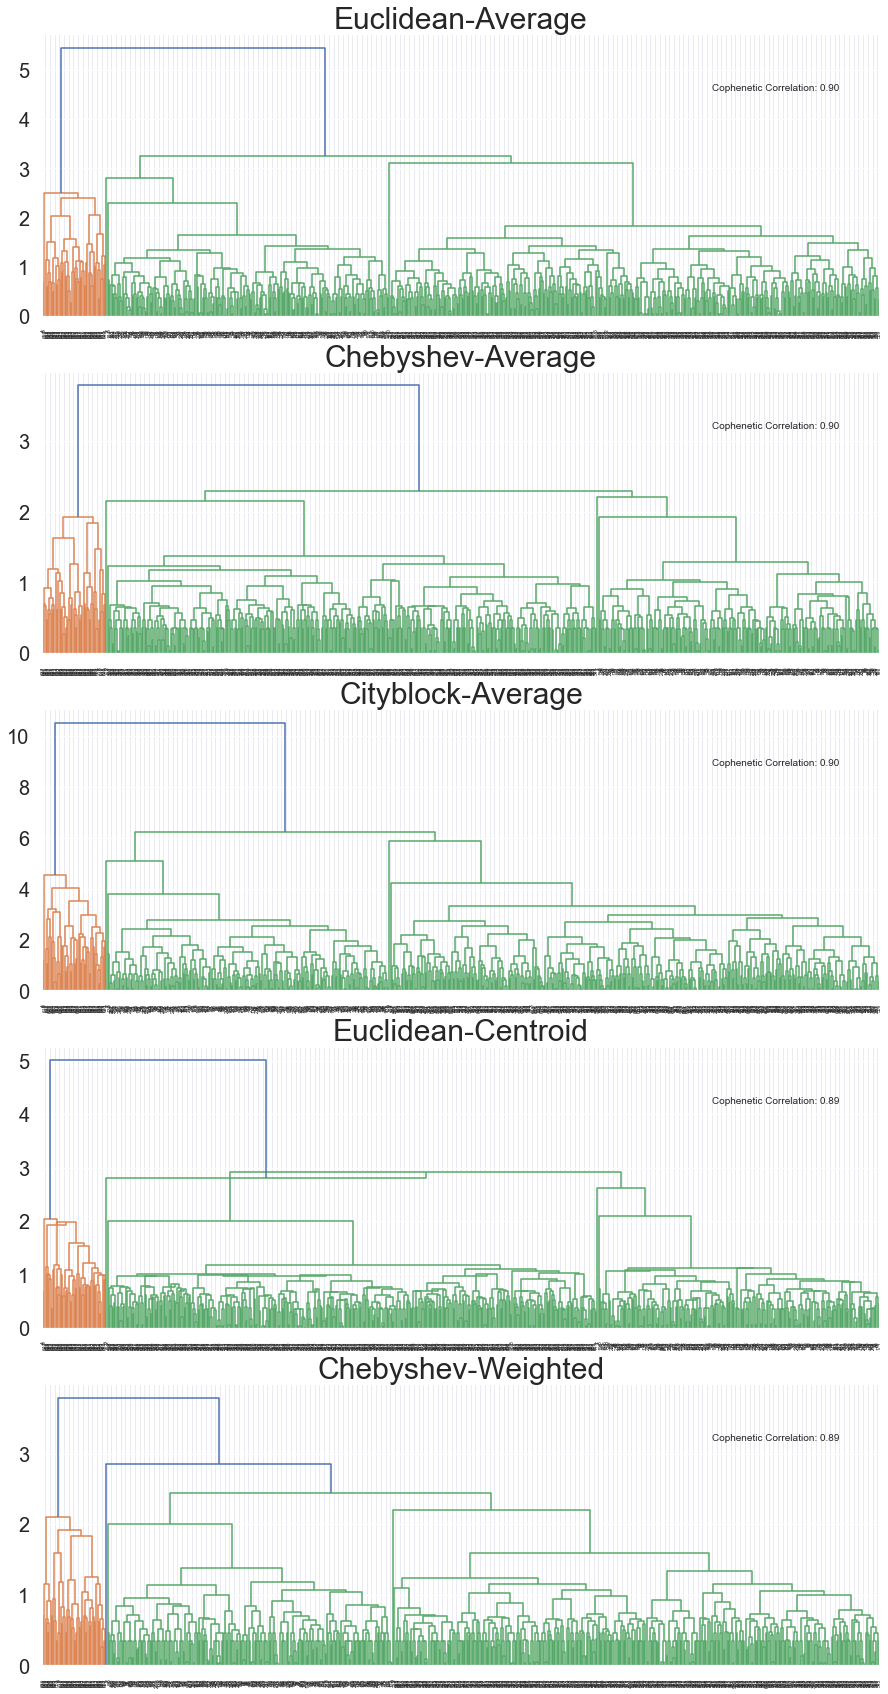

<IPython.core.display.Javascript object>

In [34]:
# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(5, 1, figsize=(15, 30))

# For top 5 linkage method ad distance, we will plot the dendrogram and calculate the cophenetic correlation
for i, row in cophenetic_corr_df.head(5).iterrows():
    dm = row["Distance"]
    lm = row["Linkage"]
    Z = linkage(scaled_df_hc, metric=dm, method=lm)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"{dm.capitalize()}-{lm.capitalize()}")

    coph_corr, coph_dist = cophenet(Z, pdist(scaled_df))
    axs[i].annotate(
        f"Cophenetic Correlation: {coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**From the dendogram for euclidean distance average linkage, 3 seems ot be appropriate number of clusters**

In [35]:
# lets use new copy of the original data
hc_data = data_org.copy()
hc_data.drop(["Sl_No", "Customer Key"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [36]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(scaled_df_hc)

AgglomerativeClustering(linkage='average', n_clusters=3)

<IPython.core.display.Javascript object>

In [37]:
scaled_df["HC_Clusters"] = HCmodel.labels_
hc_data["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

## Cluster Profiling

In [38]:
hc_cluster_profile = hc_data.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

In [39]:
hc_cluster_profile["count_in_each_segments"] = (
    hc_data.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [40]:
# let's display cluster profiles
hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,223


<IPython.core.display.Javascript object>

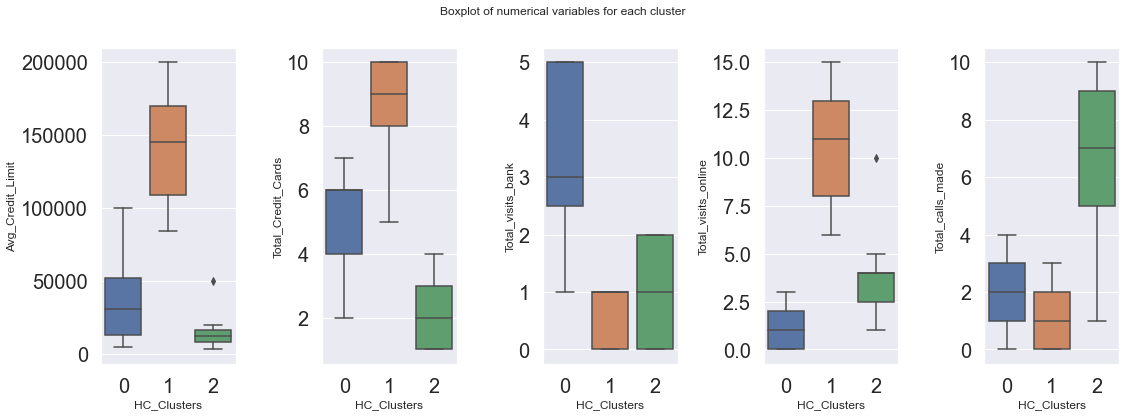

<IPython.core.display.Javascript object>

In [41]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=hc_data[hc_data.columns[counter]], x=hc_data["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

<AxesSubplot:xlabel='HC_Clusters'>

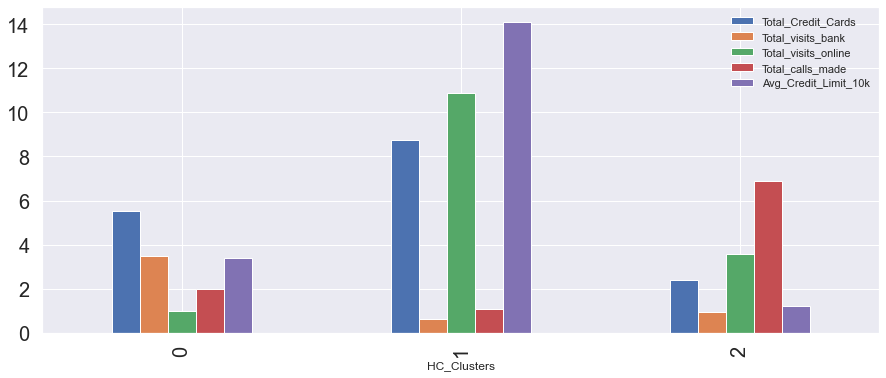

<IPython.core.display.Javascript object>

In [42]:
# for display purposes lets plot Avg_Credit_Limit per 10k
hc_data["Avg_Credit_Limit_10k"] = hc_data["Avg_Credit_Limit"]/10000
hc_data.drop("Avg_Credit_Limit",axis=1).groupby("HC_Clusters").mean().plot.bar(figsize=(15, 6))

### Insights based on Hierarchical Clustering
Using Hierarchical Clustering customes can be grouped in 3 clusters

### Cluster 1:
* There are 387 customers in this cluster
* Average Credit Limit around 35000
* Has around 5 credit cards
* Vists the bank about 3 times in a year
* Visits about 1 times online in a year
* Makes about 2 calls to the customer service in a year

### Cluster 2:
* There are 50 customers in this cluster
* Average Credit Limit around 140000
* Has around 9 credit cards
* Vists the bank less than 1 time in a year
* Visits about 11 times online in a year
* Makes about 1 call to the customer service in a year

### Cluster 3:
* There are 223 customers in this cluster
* Average Credit Limit around 10000
* Has around 2 to 3 credit cards
* Vists the bank about 1 time in a year
* Visits about 3 time online in a year
* Makes about 7 calls to the customer service in a year


## Comparing K-means and Hierarchical Clusters
Both the methods have produced almost similar clusters.

## Business Recommendations
* Both K-Means and Hierarchical clustering have identified one cluster of 50 customers. This seems to be a cluster of premimum customers with high credit limits. Bank should target marketing to attract more such customers. 
* A cluster of customers with lowest cridit limit (about 10K) are making most number of call every year. Bank shouuld try to find some kind od self-serving online solution for this group.
* The largest cluster customers make more visits to the bank than using online services. Bak should look for the reasons and promote use of online services for faster service.